In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
import pandas as pd

from utils.utils import load_data, remove_zero_features, load_confounders, standardize, generate_label_stats, generate_undersampled_set, generate_oversampled_set
from utils.plot_utils import aggregate_diagnoses, plot_diagnosis_frequency, plot_diagnosis_prevalence
from utils.plot_utils import plot_demographics, plot_feature_confounder_relation
from utils.plot_utils_umap import plot_umap_combined, plot_umap_cluster

from sklearn.model_selection import train_test_split

In [23]:
# Load data for classification task
subject_data, features, diagnoses = load_data('classification')

In [24]:
C = load_confounders(subject_data, case='raw')
D = diagnoses.iloc[:,1:]

In [25]:
# Remove zero features
F = remove_zero_features(features.iloc[:,1:])
# Standardize
X = standardize(F)
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
# Remove ID column
Y = D
print(f"Number of labels: {Y.shape[1]}")

Number of samples: 2815
Number of features: 922
Number of labels: 13


---

In [26]:
# Load data for classification task
subject_data, _, _, _ = load_data('all')

In [27]:
subject_data["Site"].value_counts()

Site
CBIC    1489
RU      1007
CUNY     612
SI       343
Name: count, dtype: int64

# 1. Demographics

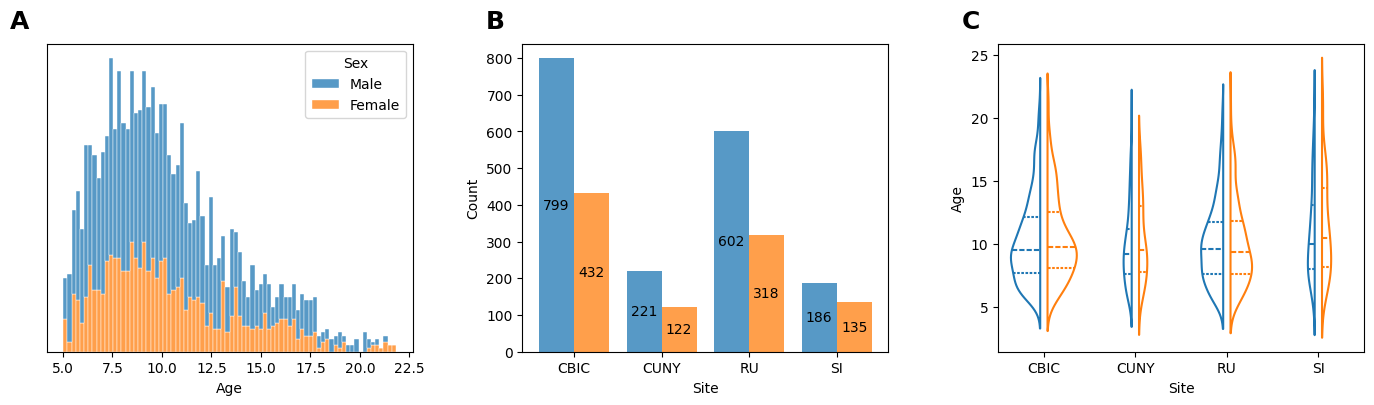

In [28]:
plot_demographics(C, 'the main dataset')

In [29]:
print(f"Mean: {C['Age'].mean():.2f}")
print(f"Std: {C['Age'].std():.2f}")
print(f"Median: {C['Age'].median():.2f}")
print(f"Min: {C['Age'].min():.2f}")
print(f"Max: {C['Age'].max():.2f}")

Mean: 10.27
Std: 3.37
Median: 9.61
Min: 5.02
Max: 21.82


In [30]:
male_female_ratio = C['Sex'].value_counts()['Male'] / C['Sex'].value_counts()['Female']
print(f"Male to Female ratio: {male_female_ratio:.2f}")

Male to Female ratio: 1.80


In [31]:
site_sex_counts = C.groupby(['Site', 'Sex']).size().unstack(fill_value=0)
site_sex_ratios = site_sex_counts['Male'] / site_sex_counts['Female']
print(site_sex_ratios)


Site
CBIC    1.849537
CUNY    1.811475
RU      1.893082
SI      1.377778
dtype: float64


In [32]:
subject_counts = C['Site'].value_counts()
print(subject_counts)

Site
CBIC    1231
RU       920
CUNY     343
SI       321
Name: count, dtype: int64


# 2. Diagnostic labels

## 2.1. Label statistics (for individual labels)

In [33]:
df = aggregate_diagnoses(C, D)

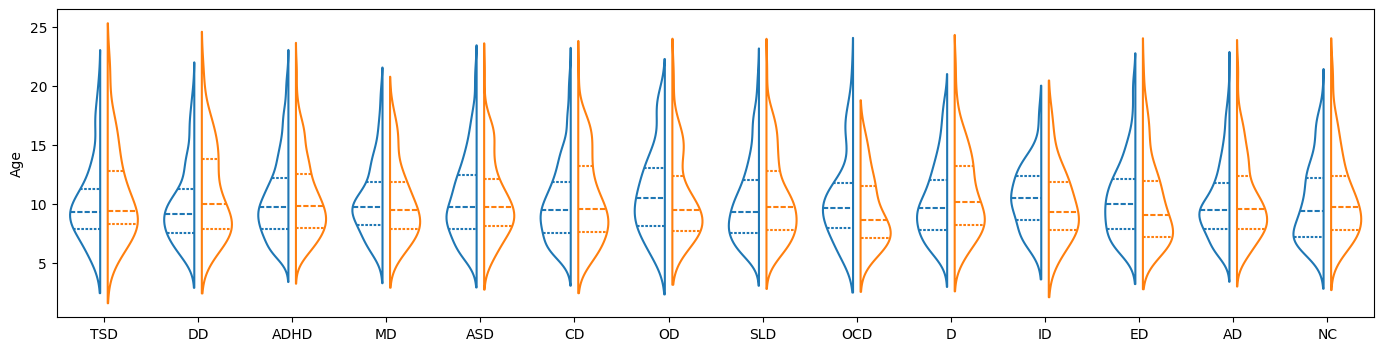

In [34]:
plot_diagnosis_frequency(df, 'morphometric_dataset')

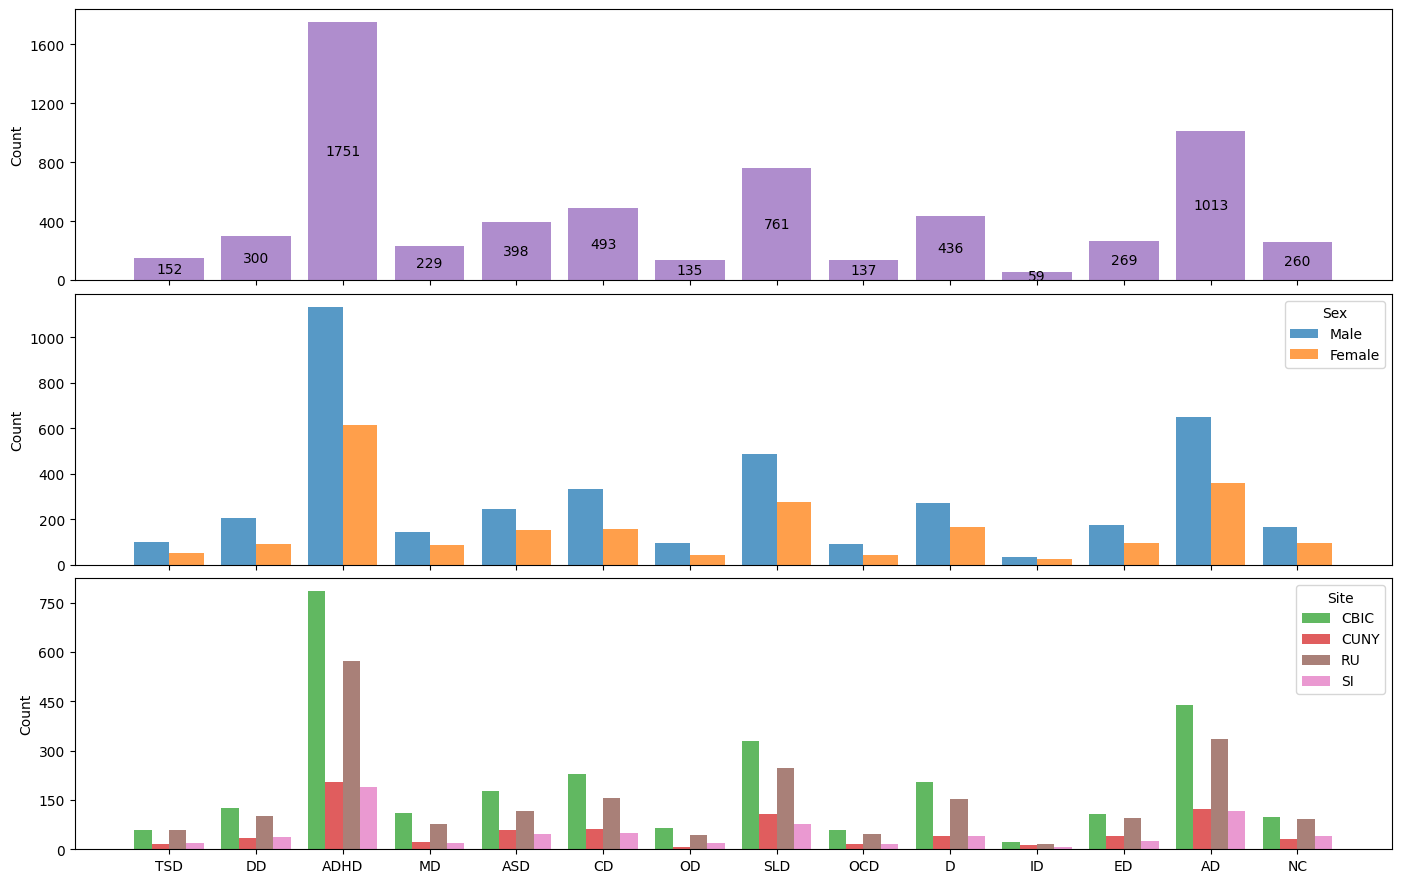

In [35]:
plot_diagnosis_prevalence(df, 'morphometric_dataset')

In [36]:
stats, mean_ir = generate_label_stats(D, mean_ir=True)
print(f"Mean imbalance ratio: {mean_ir:.4f}")
stats

Mean imbalance ratio: 7.9952


,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,152,0.053996,11.519737
DepressiveDisorders,300,0.106572,5.836667
Attention_Deficit_HyperactivityDisorder,1751,0.622025,1.000000
MotorDisorder,229,0.081350,7.646288
AutismSpectrumDisorder,398,0.141385,4.399497
CommunicationDisorder,493,0.175133,3.551724
OtherDisorders,135,0.047957,12.970370
SpecificLearningDisorder,761,0.270337,2.300920
Obsessive_Compulsive_And_RelatedDisorders,137,0.048668,12.781022
Disruptive,436,0.154885,4.016055


In [37]:
stats_sorted = stats.sort_values(by='Absolute frequency', ascending=False)
stats_sorted


,Absolute frequency,Relative frequency,Imbalance ratio
Attention_Deficit_HyperactivityDisorder,1751,0.622025,1.000000
AnxietyDisorders,1013,0.359858,1.728529
SpecificLearningDisorder,761,0.270337,2.300920
CommunicationDisorder,493,0.175133,3.551724
Disruptive,436,0.154885,4.016055
AutismSpectrumDisorder,398,0.141385,4.399497
DepressiveDisorders,300,0.106572,5.836667
EliminationDisorder,269,0.095560,6.509294
MotorDisorder,229,0.081350,7.646288
Trauma_And_Stress_RelatedDisorders,152,0.053996,11.519737


## 2.2. Set statistics (for label sets)
A label set with cardinality greater 1 is a case of comorbidity

In [38]:
print(f"Number of uniqe lable sets: {D.apply(tuple, axis=1).nunique()}")
print(f"Mean set cardinality: {D.sum(axis=1).mean():.2f}")
print(f"Median set cardinality: {D.sum(axis=1).median():.2f}")

Number of uniqe lable sets: 396
Mean set cardinality: 2.18
Median set cardinality: 2.00


In [39]:
head_size = 10
print(f"{head_size} most frequent label sets:")
combinations = D.apply(lambda x: tuple(x), axis=1).value_counts()
combinations.head(head_size)

10 most frequent label sets:


(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)    316
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)    260
(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)    116
(0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)    109
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)    100
(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)    100
(0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)     83
(0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)     68
(0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1)     52
(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0)     48
Name: count, dtype: int64

In [40]:
print("Frequency of sets with cardinality 1 (occurence of one single disorder):")
combinations = D.apply(lambda x: tuple(x), axis=1).value_counts()
combinations = combinations[combinations.index.map(lambda x: sum(x) == 1)]
combinations

Frequency of sets with cardinality 1 (occurence of one single disorder):


(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)    316
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)    100
(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)    100
(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0)     48
(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)     24
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)     23
(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)     22
(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)     22
(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)     17
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)     15
(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)     14
(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0)      9
(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0)      7
Name: count, dtype: int64

## 2.3. Label statistics for regular, undersampled and oversampled training sets

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
print(f"Number of samples in training set: {len(X_train)}")
print(f"Number of samples in test set: {len(X_test)}")

Number of samples in training set: 2111
Number of samples in test set: 704


### 2.3.1. Y_test

In [43]:
label_stats, mean_ir = generate_label_stats(Y_test, True)
print(f"Mean imbalance ratio: {mean_ir}")
label_stats

Mean imbalance ratio: 7.559406367665597


,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,43,0.061080,9.813953
DepressiveDisorders,83,0.117898,5.084337
Attention_Deficit_HyperactivityDisorder,422,0.599432,1.000000
MotorDisorder,65,0.092330,6.492308
AutismSpectrumDisorder,97,0.137784,4.350515
CommunicationDisorder,126,0.178977,3.349206
OtherDisorders,40,0.056818,10.550000
SpecificLearningDisorder,179,0.254261,2.357542
Obsessive_Compulsive_And_RelatedDisorders,40,0.056818,10.550000
Disruptive,106,0.150568,3.981132


### 2.3.2. Y_train regular

In [44]:
label_stats, mean_ir = generate_label_stats(Y_train, True)
print(f"Mean imbalance ratio: {mean_ir}")
label_stats

Mean imbalance ratio: 8.198046243793558


,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,109,0.051634,12.192661
DepressiveDisorders,217,0.102795,6.124424
Attention_Deficit_HyperactivityDisorder,1329,0.629559,1.000000
MotorDisorder,164,0.077688,8.103659
AutismSpectrumDisorder,301,0.142586,4.415282
CommunicationDisorder,367,0.173851,3.621253
OtherDisorders,95,0.045002,13.989474
SpecificLearningDisorder,582,0.275699,2.283505
Obsessive_Compulsive_And_RelatedDisorders,97,0.045950,13.701031
Disruptive,330,0.156324,4.027273


### 2.3.3. Y_train undersampled

In [45]:
X_under, Y_under = generate_undersampled_set(X_train, Y_train)
label_stats, mean_ir = generate_label_stats(Y_under, True)
print(f"Mean imbalance ratio: {mean_ir}")
label_stats

Mean imbalance ratio: 2.956543202759316


,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,38,0.051701,4.473684
DepressiveDisorders,80,0.108844,2.125000
Attention_Deficit_HyperactivityDisorder,170,0.231293,1.000000
MotorDisorder,52,0.070748,3.269231
AutismSpectrumDisorder,101,0.137415,1.683168
CommunicationDisorder,75,0.102041,2.266667
OtherDisorders,35,0.047619,4.857143
SpecificLearningDisorder,128,0.174150,1.328125
Obsessive_Compulsive_And_RelatedDisorders,32,0.043537,5.312500
Disruptive,74,0.100680,2.297297


### 2.3.4. Y_train oversampled

In [46]:
X_over, Y_over = generate_oversampled_set(X_train, Y_train)
label_stats, mean_ir = generate_label_stats(Y_over, True)
print(f"Mean imbalance ratio: {mean_ir}")
label_stats

Mean imbalance ratio: 1.6752910161710401


,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,1895,0.112296,2.105541
DepressiveDisorders,2577,0.152711,1.548312
Attention_Deficit_HyperactivityDisorder,3496,0.207170,1.141304
MotorDisorder,2386,0.141393,1.672255
AutismSpectrumDisorder,2820,0.167111,1.414894
CommunicationDisorder,3459,0.204978,1.153513
OtherDisorders,1769,0.104830,2.255512
SpecificLearningDisorder,3990,0.236444,1.000000
Obsessive_Compulsive_And_RelatedDisorders,2120,0.125630,1.882075
Disruptive,2080,0.123259,1.918269


## 2.4. Low-dimensional representation
Project labels to a lower-dimensional space using UMAP (embedding method)

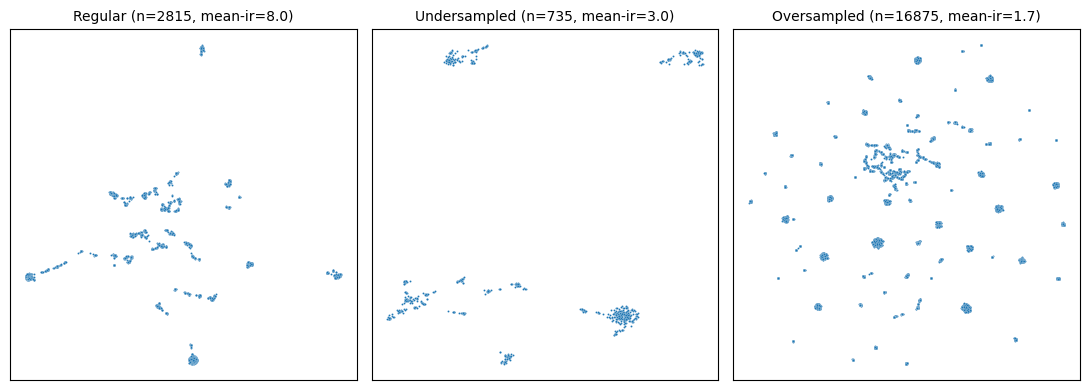

In [47]:
plot_umap_combined(X, Y, 'morphometric_dataset')

# 3. Morphometric features
Relationship between eTIV and confounding variables (age, sex)

In [48]:
F = features.iloc[:,1:]
f = pd.DataFrame()
f['TIV'] = F['global_estimatedtotalintracranialvol']
f['TIV'] = f['TIV']/1e6
df = pd.concat([f,C], axis=1)

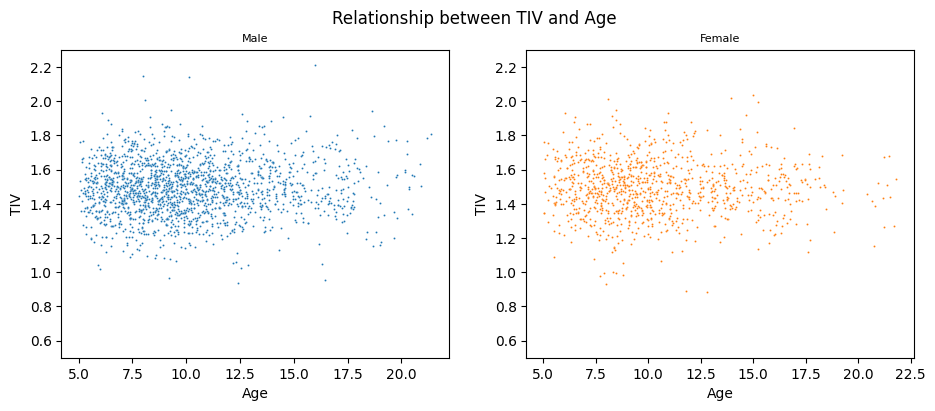

In [49]:
plot_feature_confounder_relation(df, 'TIV', 'Age', 'Sex', ['Male','Female'])

# 4. Brain images

In [50]:
# Load data for classification task
subject_data, _, diagnoses = load_data('classification_t1')

In [51]:
C = load_confounders(subject_data, case='raw')
D = diagnoses.iloc[:,1:]

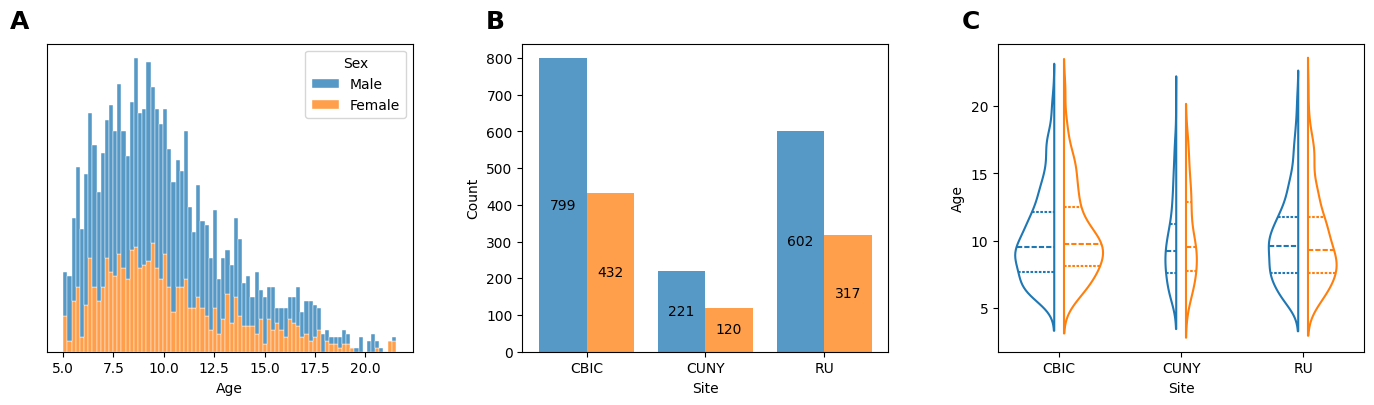

In [52]:
plot_demographics(C, 'brain_image_dataset')

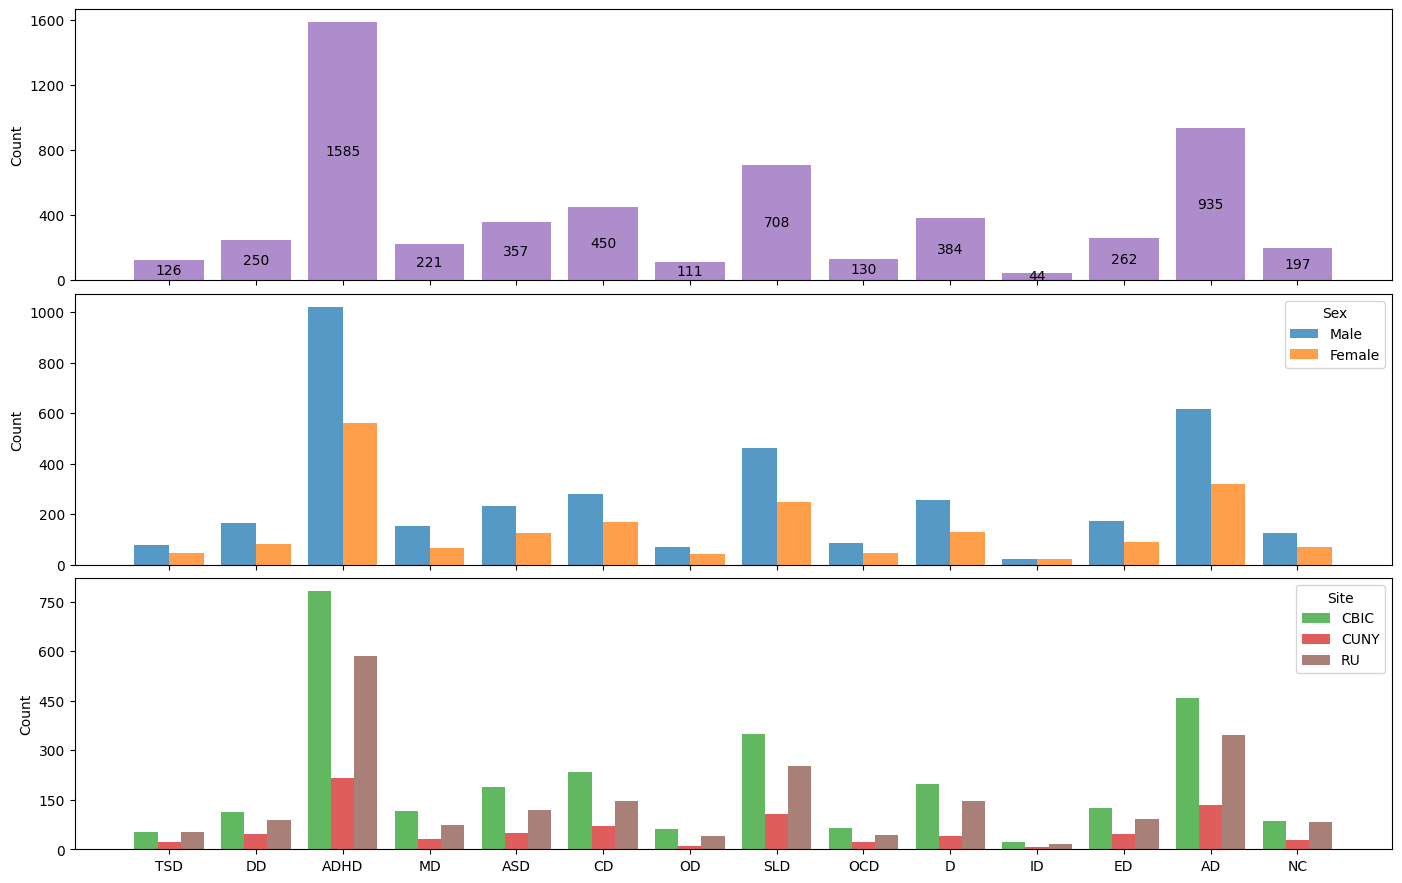

In [53]:
df = aggregate_diagnoses(C, D)
plot_diagnosis_prevalence(df, 'brain_image_dataset')